# Sheet 6

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn

# 1) Top tagging with CNNs

In [2]:
# download data to folder data04
# this might take some time (50MB)
# you can also do this manually (download + unpack zip)
import os, sys
import wget
from zipfile import ZipFile
from tqdm import tqdm

DESTINATION = "data06"
url = "https://www.thphys.uni-heidelberg.de/~plehn/pics/"
filename = "toptagging-short.zip"
url = url + filename

os.makedirs(DESTINATION, exist_ok=True)
os.chdir(DESTINATION)
wget.download(url, filename)
with ZipFile(filename, "r") as zip_ref:
    for file in tqdm(iterable=zip_ref.namelist(), total=len(zip_ref.namelist())):
        zip_ref.extract(member=file)
os.chdir("..")
%ls data06

100%|██████████| 7/7 [00:04<00:00,  1.49it/s]

 toptagging-short/       tutorial-2-data/            tutorial-2-data.zip*
 toptagging-short.zip*  'tutorial-2-data (1).zip'*


In [2]:
# load data
X_train = np.load( "data06/toptagging-short/x_train_short.npy")
y_train = np.load( "data06/toptagging-short/y_train_short.npy")
X_test = np.load( "data06/toptagging-short/x_test_short.npy")
y_test = np.load( "data06/toptagging-short/y_test_short.npy")
X_val = np.load( "data06/toptagging-short/x_val_short.npy")
y_val = np.load( "data06/toptagging-short/y_val_short.npy")

print(f"train data shape: {X_train.shape}")
print(f"train labels shape: {y_train.shape}")
print(f"test data shape: {X_test.shape}")
print(f"test labels shape: {y_test.shape}")
print(f"val data shape: {X_val.shape}")
print(f"val labels shape: {y_val.shape}")

train data shape: (30000, 200, 4)
train labels shape: (30000,)
test data shape: (30000, 200, 4)
test labels shape: (30000,)
val data shape: (30000, 200, 4)
val labels shape: (30000,)


(a)

In [3]:
# Some initial settings
__n_warning__ = 0.7
n_shift_phi, n_shift_eta = 0, 0

# Grid settings
xpixels = np.arange(-2.6, 2.6, 0.029)
ypixels = np.arange(-np.pi, np.pi, 0.035)

# Calculate the pseudorapidity of pixel entries
def eta (pT, pz):
    small = 1e-10
    small_pT = (np.abs(pT) < small)
    small_pz = (np.abs(pz) < small)
    not_small = ~(small_pT | small_pz)
    theta = np.arctan(pT[not_small]/pz[not_small])
    theta[theta < 0] += np.pi
    etas = np.zeros_like(pT)
    etas[small_pz] = 0
    etas[small_pT] = 1e-10
    etas[not_small] = np.log(np.tan(theta/2))
    return etas

# Calculate the azimuthal angle of pixel entries
def phi (px, py):
    """
    phis are returned in rad., np.arctan(0,0)=0 -> zero constituents set to -np.pi
    """
    phis = np.arctan2(py,px)
    phis[phis < 0] += 2*np.pi
    phis[phis > 2*np.pi] -= 2*np.pi
    phis = phis - np.pi 
    return phis

# function to calculate masses
def mass (E,px,py,pz):
    mass = np.sqrt(np.maximum(0.,E**2-px**2-py**2-pz**2))
    return mass

# function to return the image momenta for centroid and principal axis
def img_mom (x, y, weights, x_power, y_power):
    return ((x**x_power)*(y**y_power)*weights).sum()

# returns the jet image
def orig_image (etas, phis, es):
    """
    Gives the value on grid with minimal distance,
    eg. for xpixel = (0,1,2,3,..) eta=1.3 -> xpixel=1, eta=1.6 ->xpixel=2
    """
    z = np.zeros((etas.shape[0],len(xpixels),len(ypixels)))
    in_grid = ~((etas < xpixels[0]) | (etas > xpixels[-1]) | (phis < ypixels[0]) | (phis > ypixels[-1]))
    xcoords = np.argmin(np.abs(etas[:,None,:] - xpixels[None,:,None]),axis=1)
    ycoords = np.argmin(np.abs(phis[:,None,:] - ypixels[None,:,None]),axis=1)
    ncoords = np.repeat(np.arange(etas.shape[0])[:,None],etas.shape[1],axis=1)
    z[ncoords[in_grid],ycoords[in_grid],xcoords[in_grid]] = es[in_grid]
    return z

# preprocess the jet
def preprocessing( x ,y, weights, rotate=True, flip=True ):
    """
    (x,y) are the coordinates and weights the corresponding values, shifts
    centroid to origin, rotates image, so that principal axis is vertical,
    flips image, so that most weights lay in (x<0, y>0)-plane.
    Method for calculating principal axis (similar to tensor of inertia):
    https://en.wikipedia.org/wiki/Image_moment
    here: y=phi, phi has modulo 2*np.pi but it's not been taken care of hear,
    so possible issues with calculating the centroid
    -> pre-shifting of events outside of this function solves the problem
    for iamge-data with Delta_phi < 2*np.pi
    """

    # Shift
    x_centroid = img_mom(x, y, weights, 1, 0) / weights.sum()
    y_centroid = img_mom(x, y, weights, 0, 1)/ weights.sum()
    x = x - x_centroid
    y = y - y_centroid

    # Check if shifting worked, there can be problems with modulo variables like phi (y)
    # x and y are sorted after highest weight, 0-comp. gives hottest event
    # for Jet-like Images Centroid should be close to hottest constituen (pT-sorted arrays)  
    global n_shift_phi
    global n_shift_eta
    if np.abs(x[0]) > __n_warning__:
        n_shift_eta += 1  
    if np.abs(y[0]) > __n_warning__:
        n_shift_phi += 1       

    if rotate:
        #Ccovariant matrix, eigenvectors corr. to principal axis
        u11 = img_mom(x, y, weights, 1, 1) / weights.sum()
        u20 = img_mom(x, y, weights, 2, 0) / weights.sum()
        u02 = img_mom(x, y, weights, 0, 2) / weights.sum()
        cov = np.array([[u20, u11], [u11, u02]])

        # Eigenvalues and eigenvectors of covariant matrix
        evals, evecs = np.linalg.eig(cov)

        # Sorts the eigenvalues, v1, [::-1] turns array around, 
        sort_indices = np.argsort(evals)[::-1]
        e_1 = evecs[:, sort_indices[0]]  # Eigenvector with largest eigenvalue
        e_2 = evecs[:, sort_indices[1]]

        # Theta to x_asix, arctan2 gives correct angle
        theta = np.arctan2(e_1[0], e_1[1])
  
        # Rotation, so that princple axis is vertical
        # anti-clockwise rotation matrix
        rotation = np.matrix([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
        transformed_mat = rotation * np.stack([x,y])
        x_rot, y_rot = transformed_mat.A
    else: 
        x_rot, y_rot = x, y
  
    # Flipping
    n_flips = 0
    if flip:
        if weights[x_rot<0.].sum() < weights[x_rot>0.].sum():
            x_rot = -x_rot
            n_flips  += 1
        if weights[y_rot<0.].sum() > weights[y_rot>0.].sum():
            y_rot = -y_rot
            n_flips += 1
            
    return x_rot, y_rot


# function to convert the jet to an image
def constit_to_img( jets, n_constit, norm, rotate, flip ):
    
    print( "Crop constituents" )
    jets = jets[:,0:n_constit,:]
    
    print( "Calculating pT" )
    E     = jets[:,:,0]
    pxs   = jets[:,:,1]
    pys   = jets[:,:,2]
    pzs   = jets[:,:,3]
    pT    = np.sqrt(pxs**2+pys**2)
    
    print( "Calculating eta" )
    etas  = eta(pT,pzs)
    
    print( "Calculating phi" )
    phis  = phi(pxs,pys)
    
    print( "Calculating the mass" )
    E_tot = E.sum(axis=1)
    px_tot = pxs.sum(axis=1)
    py_tot = pys.sum(axis=1)
    pz_tot = pzs.sum(axis=1)
    j_mass = mass(E_tot, px_tot, py_tot, pz_tot)
    
    print( "Pre-shifting the phis" )
    phis = (phis.T - phis[:,0]).T
    phis[phis < -np.pi] += 2*np.pi
    phis[phis > np.pi] -= 2*np.pi
    
    print( "Using pT as weight" )
    weights = pT
    
    print( "Preprocessing" )
    
    for i in range( np.shape(etas)[0] ):
        etas[i,:], phis[i,:] = preprocessing( etas[i,:], phis[i,:], weights[i,:], rotate, flip )
    
    print( "Creating images" )
    z_ori = orig_image(etas, phis, weights)
    
    #return z_ori
        
    print( "Cropping and normalising" )
    n_crop = 40
    z_new = np.zeros( (z_ori.shape[0],n_crop, n_crop) )
    for i in range(z_ori.shape[0]):
        Npix = z_ori[i,:,:].shape
        z_new[i,:,:] = z_ori[i, int(Npix[0]/2-n_crop/2) : int(Npix[0]/2+n_crop/2), int(Npix[1]/2-n_crop/2) : int(Npix[1]/2+n_crop/2) ]
        if norm:
            z_sum = z_new[i,:,:].sum()
            if z_sum != 0.:
                z_new[i,:,:] = z_new[i,:,:]/z_sum
    
    print( "Reshaping" )
    z_out = z_new.reshape( (z_new.shape[0],-1) ).reshape(-1, 1, 40,40)
    
    return z_out

In [4]:
# needs roughly 3GB of RAM in orig_image
# reduce the number of events in the dataset if needed
z_train = constit_to_img( X_train, 50, True, True, True )
z_test = constit_to_img( X_test, 50, True, True, True )
z_val = constit_to_img( X_val, 50, True, True, True )
print(z_train.shape)

Crop constituents
Calculating pT
Calculating eta
Calculating phi
Calculating the mass
Pre-shifting the phis
Using pT as weight
Preprocessing
Creating images
Cropping and normalising
Reshaping
Crop constituents
Calculating pT
Calculating eta
Calculating phi
Calculating the mass
Pre-shifting the phis
Using pT as weight
Preprocessing
Creating images
Cropping and normalising
Reshaping
Crop constituents
Calculating pT
Calculating eta
Calculating phi
Calculating the mass
Pre-shifting the phis
Using pT as weight
Preprocessing
Creating images
Cropping and normalising
Reshaping
(30000, 1, 40, 40)


In [5]:
sig = z_train[ np.where(y_train==1) ]
bkg = z_train[ np.where(y_train==0) ]

<ipython-input-7-85fd504e4f81>:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


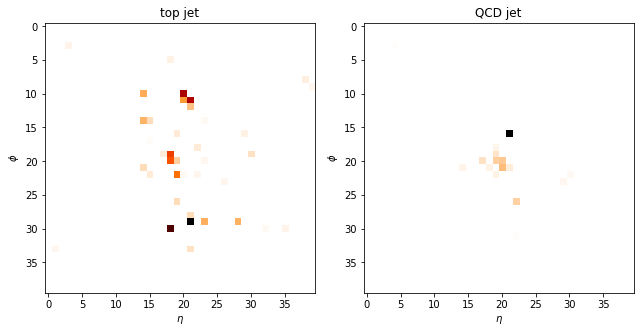

In [7]:
fig, axs = plt.subplots( 1, 2, figsize=(9,5) )

axs[0].imshow( sig[0,0,...], cmap="gist_heat_r" )
axs[0].set_xlabel( "$\eta$" )
axs[0].set_ylabel( "$\phi$" )
axs[0].set_title("top jet")

axs[1].imshow( bkg[0,0,...], cmap="gist_heat_r" )
axs[1].set_xlabel( "$\eta$" )
axs[1].set_ylabel( "$\phi$")
axs[1].set_title("QCD jet")

fig.tight_layout()

fig.show()

<ipython-input-8-1e3248fdf2ae>:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


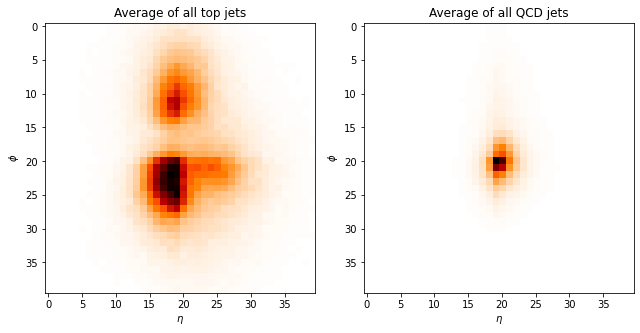

In [8]:
fig, axs = plt.subplots( 1, 2, figsize=(9,5) )

axs[0].imshow( sig.mean(0)[0,...], cmap="gist_heat_r" )
axs[0].set_xlabel( "$\eta$" )
axs[0].set_ylabel( "$\phi$" )
axs[0].set_title("Average of all top jets")

axs[1].imshow( bkg.mean(0)[0,...], cmap="gist_heat_r" )
axs[1].set_xlabel( "$\eta$" )
axs[1].set_ylabel( "$\phi$")
axs[1].set_title("Average of all QCD jets")

fig.tight_layout()

fig.show()

(b)

In [9]:
def my_BCELoss(scores, labels):
    loss_true = - labels * torch.log(scores)
    loss_fake = - (1-labels) * torch.log(1-scores)
    loss = loss_true.mean() + loss_fake.mean()
    return loss

In [10]:
n = 10
x = torch.rand(2 * n, 1)
y = torch.cat((torch.ones(n, 1), torch.zeros(n, 1)))
my_bce = my_BCELoss(x, y)
bceloss = nn.BCELoss()
torch_bce = bceloss(x, y)

print(f"custom BCE: \t{my_bce:.4f}")
print(f"torch BCE: \t{torch_bce:.4f}")

custom BCE: 	0.6953
torch BCE: 	0.6953


(c)

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [12]:
class cnn_data( torch.utils.data.Dataset ):
    
    def __init__( self, imgs, labels ):
        self.imgs = imgs
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.imgs[idx], self.labels[idx]

In [13]:
z_train_torch = torch.Tensor(z_train).float()
z_test_torch = torch.Tensor(z_test).float()
z_val_torch = torch.Tensor(z_val).float()

y_train_torch = torch.Tensor(y_train).unsqueeze(-1)
y_test_torch = torch.Tensor(y_test).unsqueeze(-1)
y_val_torch = torch.Tensor(y_val).unsqueeze(-1)

train_cnn_dataset = cnn_data(z_train_torch, y_train_torch.float())
test_cnn_dataset = cnn_data(z_test_torch, y_test_torch.float())
val_cnn_dataset = cnn_data(z_val_torch, y_val_torch.float())

trn_dataloader = torch.utils.data.DataLoader( train_cnn_dataset, batch_size=64, shuffle=True )
tst_dataloader = torch.utils.data.DataLoader( test_cnn_dataset, batch_size=64, shuffle=False )
val_dataloader = torch.utils.data.DataLoader( val_cnn_dataset, batch_size=64, shuffle=False )

In [14]:
class ConvNet2D(nn.Module):
    
    def __init__(self, in_ch=1, ch=4, out_dim=1, img_sz=40):
        super().__init__()
        conv1 = nn.Conv2d(in_ch, ch, kernel_size=5, bias=True, stride=1, padding=2)
        conv2 = nn.Conv2d(ch, 1, kernel_size=5, bias=True, stride=1, padding=2)
        maxpool = nn.MaxPool2d(kernel_size=2)
        flatten = nn.Flatten()
        out = nn.Linear(int(img_sz*img_sz/16), out_dim, bias=True)
        
        self.net = nn.Sequential(
            conv1,
            nn.ReLU(),
            maxpool,
            nn.ReLU(),
            conv2,
            maxpool,
            flatten,
            out,
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.net(x)
    

In [15]:
def batch_loss(model, loss_fn, x, y):
    x, y = x.to(device), y.to(device)
    pred = model(x)
    loss = loss_fn(pred, y)
    return loss

In [16]:
def train_epoch(model, dataloader, loss_fn, losses, batch_loss_fn):
    for x, y in dataloader:
        optimizer.zero_grad()
        
        loss = batch_loss_fn(model, loss_fn, x, y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return losses

In [17]:
def val_epoch(model, dataloader, loss_fn, losses, batch_loss_fn):
    losses_epoch = []
    with torch.no_grad():
        for x, y in dataloader:
            loss = batch_loss_fn(model, loss_fn, x,y)
            losses_epoch.append(loss.item())
    losses.append(np.mean(losses_epoch))
    return losses

In [19]:
n_epochs = 10
loss_fn = my_BCELoss

model = ConvNet2D().to(device)
print(model)
total_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model has {total_parameters:d} trainable parameters")

learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_losses = []
val_losses = []
for epoch in range(n_epochs):
    train_losses = train_epoch(model, trn_dataloader, loss_fn, train_losses, batch_loss)
    
    val_losses = val_epoch(model, val_dataloader, loss_fn, val_losses, batch_loss)
    
    if epoch%1==0:
        print(f"{epoch} / {n_epochs}")

ConvNet2D(
  (net): Sequential(
    (0): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
    (4): Conv2d(4, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=100, out_features=1, bias=True)
    (8): Sigmoid()
  )
)
Model has 306 trainable parameters
0 / 10
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10


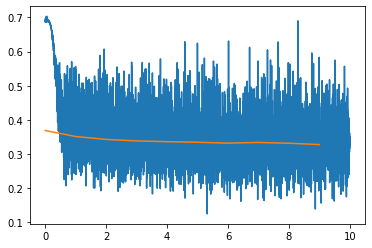

In [20]:
# plot loss
plt.plot(np.arange(len(train_losses)) / len(trn_dataloader), train_losses)
plt.plot(np.arange(len(val_losses)), val_losses)
plt.show()

In [21]:
# evaluate classifier
train_pred = model(z_train_torch).detach()
test_pred = model(z_test_torch).detach()
val_pred = model(z_val_torch).detach()

train_pred_lab = torch.round(train_pred)
test_pred_lab = torch.round(test_pred)
val_pred_lab = torch.round(val_pred)

train_correct = (train_pred_lab==y_train_torch).sum().item()
test_correct = (test_pred_lab==y_test_torch).sum().item()
val_correct = (val_pred_lab==y_val_torch).sum().item()

In [22]:
print('Evaluation of accuracy: ')
print('Accuracy on training dataset: {:.1f} %'.format(train_correct*100/len(train_pred)))
print('Accuracy on validation dataset: {:.1f} %'.format(val_correct*100/len(val_pred)))
print('Accuracy on test dataset: {:.1f} %'.format(test_correct*100/len(test_pred)))

Evaluation of accuracy: 
Accuracy on training dataset: 86.5 %
Accuracy on validation dataset: 86.6 %
Accuracy on test dataset: 86.3 %


In [23]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, th = roc_curve(y_test_torch[:,0], 
                         test_pred[:,0])
auc_score = roc_auc_score(y_test_torch[:,0], 
                         test_pred[:,0])

<ipython-input-24-7fea4c79653d>:12: RuntimeWarning: divide by zero encountered in divide
  ax[1].plot(tpr, 1/fpr, label=f'AUC = {auc_score:.2f}' )
<ipython-input-24-7fea4c79653d>:13: RuntimeWarning: divide by zero encountered in divide
  ax[1].plot(rnd_class, 1/rnd_class, '--', label='Rnd classifier')
<ipython-input-24-7fea4c79653d>:20: RuntimeWarning: divide by zero encountered in divide
  ax[2].plot(tpr, tpr/fpr**.5, label=f'AUC = {auc_score:.2f}' )
<ipython-input-24-7fea4c79653d>:20: RuntimeWarning: invalid value encountered in divide
  ax[2].plot(tpr, tpr/fpr**.5, label=f'AUC = {auc_score:.2f}' )


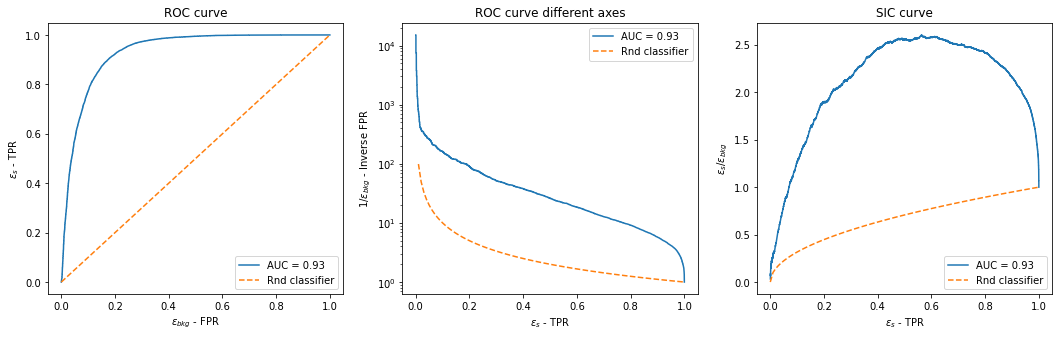

In [24]:
fig, ax = plt.subplots(1, 3, figsize=(18,5))
rnd_class = np.linspace(0, 1, 100)

ax[0].set_title("ROC curve")
ax[0].plot(fpr, tpr, label=f'AUC = {auc_score:.2f}' )
ax[0].plot(rnd_class, rnd_class, '--', label='Rnd classifier')
ax[0].set_xlabel('$\epsilon_{bkg}$ - FPR')
ax[0].set_ylabel('$\epsilon_{s}$ - TPR')
ax[0].legend()

ax[1].set_title("ROC curve different axes")
ax[1].plot(tpr, 1/fpr, label=f'AUC = {auc_score:.2f}' )
ax[1].plot(rnd_class, 1/rnd_class, '--', label='Rnd classifier')
ax[1].set_xlabel('$\epsilon_{s}$ - TPR')
ax[1].set_ylabel('1/$\epsilon_{bkg}$ - Inverse FPR')
ax[1].set_yscale('log')
ax[1].legend()

ax[2].set_title("SIC curve")
ax[2].plot(tpr, tpr/fpr**.5, label=f'AUC = {auc_score:.2f}' )
ax[2].plot(rnd_class, rnd_class**.5, '--', label='Rnd classifier')
ax[2].set_xlabel('$\epsilon_{s}$ - TPR')
ax[2].set_ylabel('$\epsilon_s /\epsilon_{bkg}$')
ax[2].legend()

plt.show()

# 2) Implementing Transformers with a Transformer

In [25]:
import math

class SelfAttention(nn.Module):
    # Adapted from https://github.com/karpathy/minGPT

    def __init__(self, block_size, n_embd, n_head=1, 
                 resid_pdrop=0.1, attn_pdrop=0., mask=True):
        super().__init__()
        assert n_embd % n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(n_embd, 3 * n_embd)
        # output projection
        self.c_proj = nn.Linear(n_embd, n_embd)
        # regularization
        self.attn_dropout = nn.Dropout(attn_pdrop)
        self.resid_dropout = nn.Dropout(resid_pdrop)
        # causal mask to ensure that attention is only applied to the left in the input sequence
        self.register_buffer("bias", torch.tril(torch.ones(block_size, block_size))
                                     .view(1, 1, block_size, block_size))
        self.n_head = n_head
        self.n_embd = n_embd
        self.mask = mask

    def forward(self, x, return_att=False):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k ,v  = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        if self.mask:
            att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
        att = nn.functional.softmax(att, dim=-1)
        att = self.attn_dropout(att)
        y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

        # output projection
        y = self.resid_dropout(self.c_proj(y))
        
        if return_att:
            return y, att
        else:
            return y

In [26]:
layer = SelfAttention(10, 32, n_head=4)
x = torch.randn(64, 10, 32)
y, att = layer(x, return_att=True)
print(x.shape, y.shape, att.shape)

torch.Size([64, 10, 32]) torch.Size([64, 10, 32]) torch.Size([64, 4, 10, 10])


Output Shape: torch.Size([4, 10, 16])


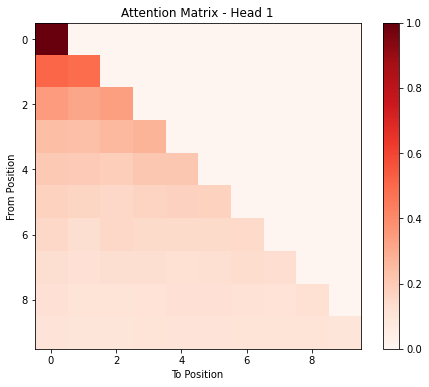

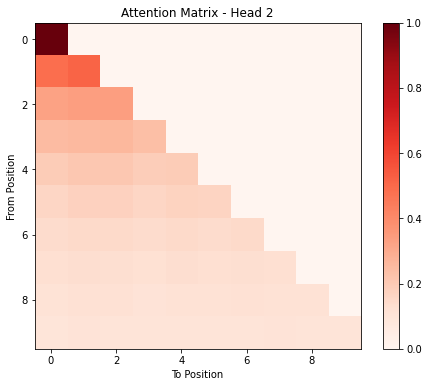

In [27]:
def generate_synthetic_data(batch_size, sequence_length, embedding_dim):
    return torch.rand((batch_size, sequence_length, embedding_dim))

def plot_attention_matrix(attention_matrix, head_idx):
    plt.figure(figsize=(8, 6))
    plt.imshow(attention_matrix.squeeze().numpy(), cmap="Reds", interpolation="nearest")
    plt.title(f"Attention Matrix - Head {head_idx + 1}")
    plt.xlabel("To Position")
    plt.ylabel("From Position")
    plt.colorbar()
    plt.show()


# Parameters
block_size = 10
n_embd = 16
n_head = 2

# Create the SelfAttention module
self_attention = SelfAttention(block_size, n_embd, n_head)

# Generate synthetic input data
x = generate_synthetic_data(batch_size=4, sequence_length=block_size, embedding_dim=n_embd)

# Forward pass through the SelfAttention module
output = self_attention(x)

# Print the output shape
print("Output Shape:", output.shape)

# Plot attention matrices for each head
with torch.no_grad():
    # Extract attention matrix for the first sample in the batch and the specified head
    _, att = self_attention(x, return_att=True)
    
    for head_idx in range(n_head):
        attention_matrix=att[0,head_idx,...]
        
        # Plot the attention matrix
        plot_attention_matrix(attention_matrix, head_idx)
